This notebook shows the development of functions used to visualize the circulation during upwelling events.

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

In [2]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']

coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_1'
grid, lon, lat, tem, sal, ssh, U, V, W, tmask = functions_plot.load_model_output(path, cfg)
utau, vtau = functions_plot.load_model_other(path, cfg)
depth_levels = grid['deptht'][:]

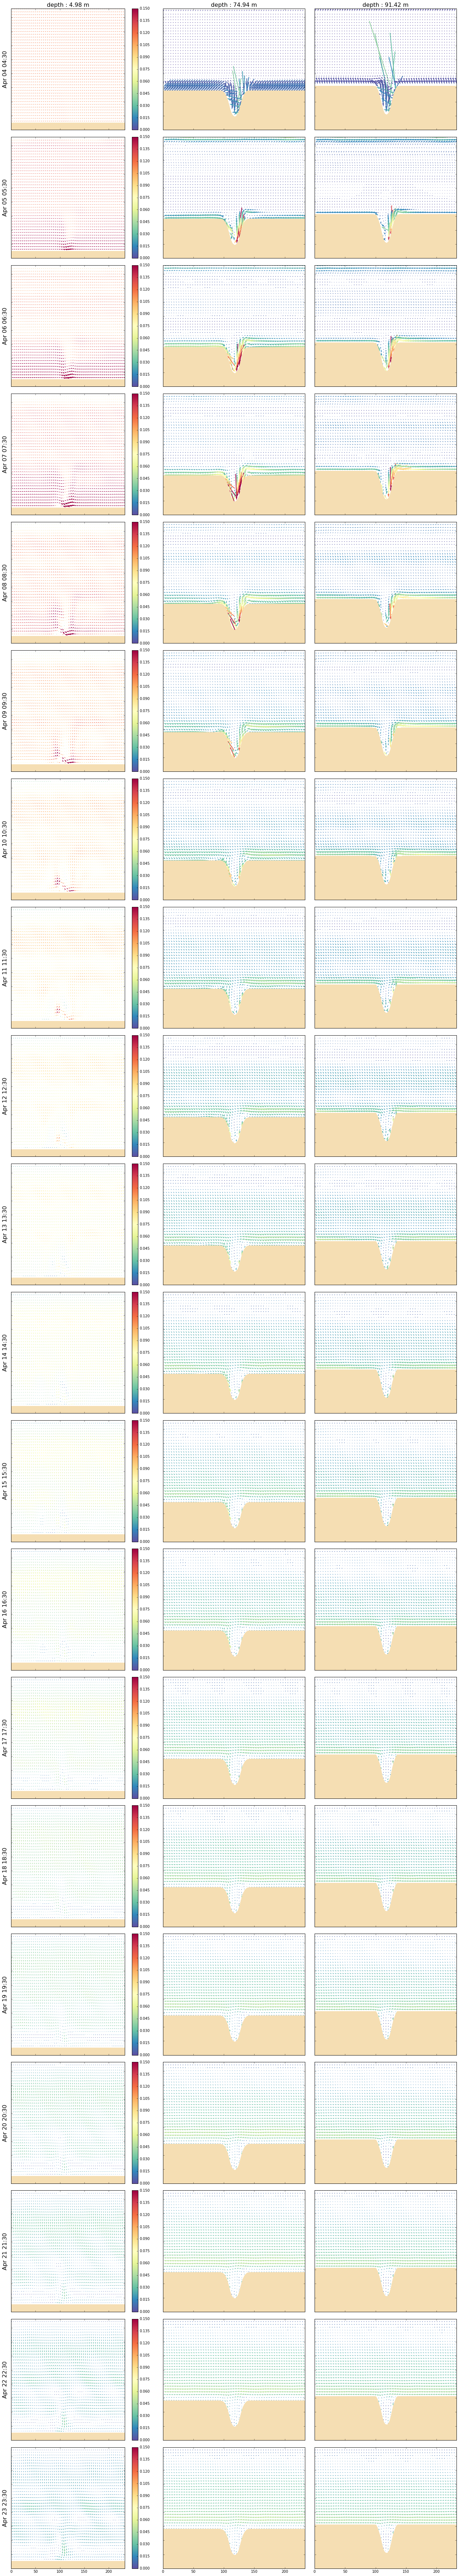

In [3]:
depth_inds = [0, 6, 7]
time_inds = np.linspace(4, 479, 20)
fig = functions_profiles.plot_quiver_stories(U, V, grid, depth_inds, time_inds, 0.15, 4, bathy_file)

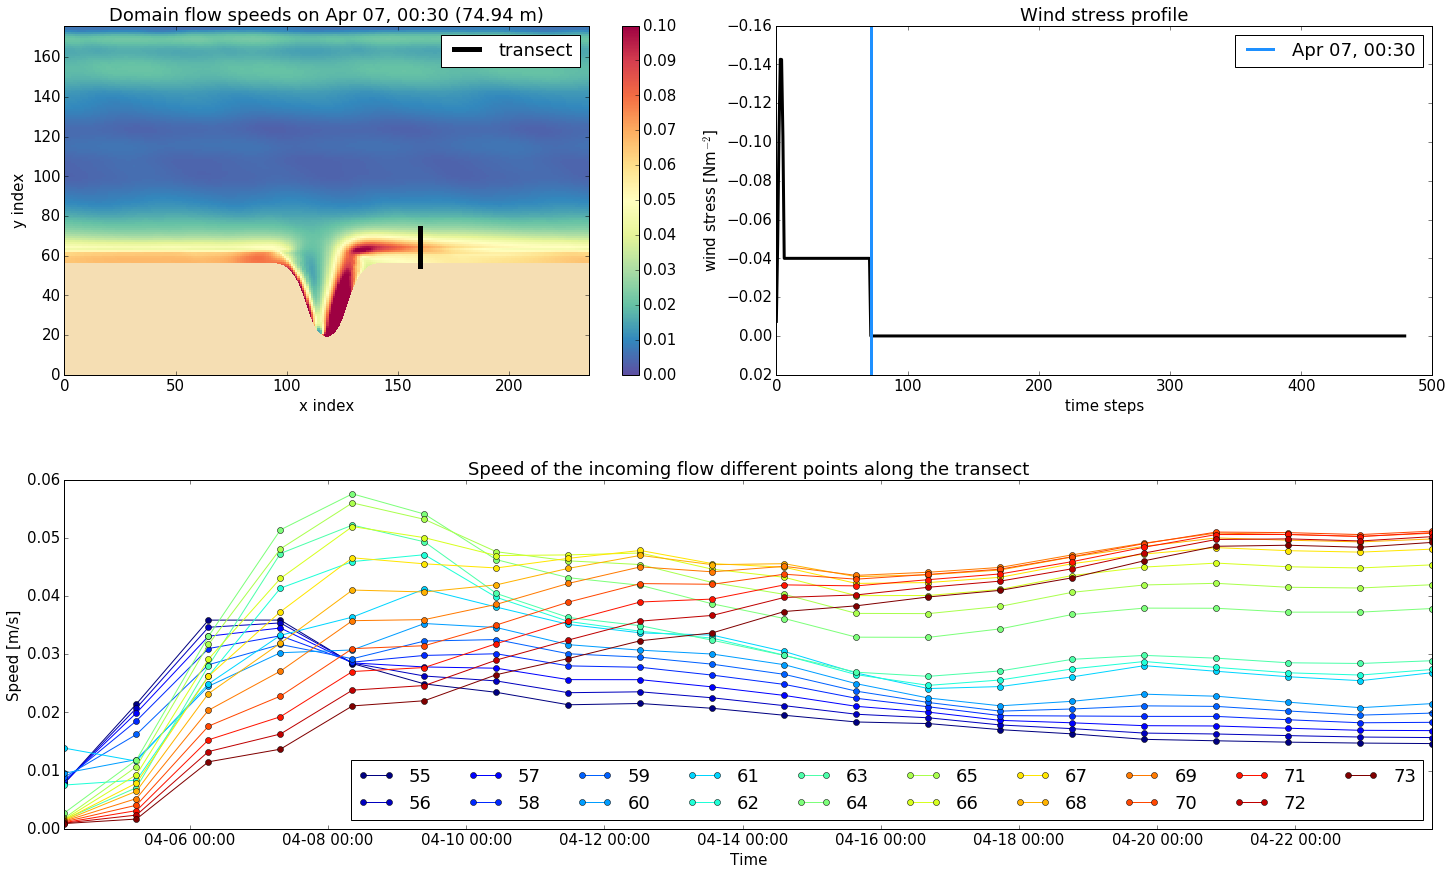

In [248]:
def plot_incoming_speeds(U_vel, V_vel, gridT, depth_ind, time_inds, time_shot, max_vel, bathy_file, utau):
    
    # definitions
    x_point = 160; y_min = 55; y_max = 75
    dep_m = round(gridT['deptht'][:][depth_ind],2)
    matplotlib.rcParams.update({'font.size': 15})

    fig = plt.figure(figsize=(20,12))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,1,2)
    fig.tight_layout()
    
    # find the speed at a depth and time to create pcolor
    x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_shot, 1)
    p = ax1.pcolor(speeds, vmin=0, vmax=max_vel, cmap='Spectral_r')
    viz_tools.plot_land_mask(ax1, bathy_file,'grid', dep_m, None, None, 'wheat')
    timestamp = nc_tools.timestamp(gridT, time_shot).format('MMM DD, HH:mm')
    ax1.set_title('Domain flow speeds on ' + timestamp + ' (' + str(dep_m) + ' m)')
    fig.colorbar(p, ax=ax1); ax1.set_ylabel('y index'); ax1.set_xlabel('x index')
    
    # define and plot the transect
    y_line = np.arange(y_min,y_max)
    x_line = np.ones_like(y_line)*x_point
    ax1.plot(x_line, y_line, linewidth=5, c='k', label='transect'); ax1.legend(loc=1)
    
    # plot the wind stress
    ax2.plot(np.arange(len(utau)), utau[:,-1,-1], c='k', lw=3)
    ax2.axvline(time_shot, c = 'dodgerblue', lw=3, label=timestamp)
    ax2.legend(loc=1);ax2.invert_yaxis()
    ax2.set_title('Wind stress profile'); ax2.set_xlabel('time steps'); ax2.set_ylabel('wind stress [Nm$^{-2}$]')

    # crop the velocities for the transect
    U_vel = U_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    V_vel = V_vel[:, :, y_min:y_max, x_point-1:x_point+1]
    
    # get the speeds along the transect at every time index and then store in a matrix
    len_y = len(y_line)-1
    speeds_all = np.zeros([len_y,len(time_inds)])
    for time_ind, m in zip(time_inds, np.arange(len(time_inds))):
        x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, depth_ind, time_ind, 1)
        for n in zip(np.arange(len_y)):
            speeds_all[n, m] = speeds[n, :]
    
    # define colors for every point along the transect
    cms = np.linspace(0, 1, len_y)
    cs = [ cm.jet(x) for x in cms]
    
    # convert all time indices into datetimes and convert these into matplotlib version
    dates = []
    for i in np.arange(len(time_inds)):
        dates.append(nc_tools.get_datetimes(grid)[time_inds[i]])
    dates = matplotlib.dates.date2num(dates)
    
    # plot speeds at every point and use plot_date to use matplotlib's datetime 
    for n in np.arange(len_y):
        ax3.plot_date(dates, speeds_all[n, :], color = cs[n], linestyle='-', label = str(y_line[n]))
        ax3.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))

    ax3.legend(ncol=10, loc=4)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Speed [m/s]')
    ax3.set_title('Speed of the incoming flow different points along the transect')
    fig.subplots_adjust(hspace=.3)
    plt.show()
    

    return fig

time_shot = 25920; nn_write_hr = 1; rn_rdt = 10; nn_write = nn_write_hr*60*60/rn_rdt
time_shot = time_shot / nn_write
time_inds = np.linspace(4, 479, 20)
fig = plot_incoming_speeds(U, V, grid, 6, time_inds, time_shot, 0.1, bathy_file, utau)